# 02: Measure LLM Efficiency

## 1. Imports

In [1]:
import gc
# import os
# CACHE_PATH = '<path_to_cache>'
# os.environ["TORCH_HOME"] = CACHE_PATH
# os.environ["HF_HOME"] = CACHE_PATH
# os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_PATH
# os.environ["HUGGINGFACE_ASSETS_CACHE"] = CACHE_PATH
# os.environ["TRANSFORMERS_CACHE"] = CACHE_PATH

import matplotlib.pyplot as plt
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
# from huggingface_hub import login; login(token="<hf_token>")

from pruna.data.pruna_datamodule import PrunaDataModule
from pruna.evaluation.evaluation_agent import EvaluationAgent
from pruna.evaluation.metrics.metric_elapsed_time import ElapsedTimeMetric
from pruna.evaluation.metrics.metric_torch import TorchMetricWrapper
from pruna.evaluation.metrics.metric_energy import EnergyMetric
from pruna.evaluation.metrics.metric_memory import GPUMemoryMetric
from pruna.evaluation.metrics.metric_model_architecture import ModelArchitectureMetric
from pruna.evaluation.task import Task

## 1. Load the LLM

First, load one LLM. There is a list of preselected LLMs with small size. Feel free to try other models until the GPU memory is not enough!

In [2]:
model_ids = [
    "facebook/opt-125m",
    "facebook/opt-350m", 
    "facebook/opt-1.3b",
    "facebook/opt-2.7b",
    "meta-llama/Llama-3.2-1B",
    "meta-llama/Llama-3.2-1B-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    # "google/gemma-3-1b-it",
    # "google/gemma-3-4b-it",
    # "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    # "microsoft/Phi-4-mini-instruct",
    # "HuggingFaceTB/SmolLM-135M",
    # "HuggingFaceTB/SmolLM-135M-instruct",
    # "HuggingFaceTB/SmolLM-360M", 
    # "HuggingFaceTB/SmolLM-360M-Instruct",
    # "HuggingFaceTB/SmolLM-1.7B",
    # "HuggingFaceTB/SmolLM-1.7B-Instruct",
    # "HuggingFaceTB/SmolLM2-135M",
    # "HuggingFaceTB/SmolLM2-135M-Instruct",
    # "HuggingFaceTB/SmolLM2-360M",
    # "HuggingFaceTB/SmolLM2-360M-Instruct", 
    # "HuggingFaceTB/SmolLM2-1.7B",
    # "HuggingFaceTB/SmolLM2-1.7B-Instruct",
    # "PleIAs/Pleias-350m-Preview",
    # "PleIAs/Pleias-Pico",
    # "PleIAs/Pleias-1.2b-Preview",
    # "PleIAs/Pleias-Nano",
    # "PleIAs/Pleias-3b-Preview",
]

## 2. Utils

The utils functions help for:
- Load from a list of (small) models. Feel free to try other models until the GPU memory is not enough!
- Make plots.
- Iterate over evaluation and model configurations.

In [3]:
def plot_results(results, metric_name):
    """
    Create a bar plot comparing results across models for a given metric.
    
    Args:
        results (dict): Dictionary with model IDs as keys and evaluation results as values
        metric_name (str): Name of the metric to plot
    """
    # Store results in a file
    import json
    import os    
    os.makedirs('results', exist_ok=True)
    results_file = f'results/{metric_name}_results.json'
    filtered_results = {model_id: result[metric_name] for model_id, result in results.items()}
    with open(results_file, 'w') as f:
        json.dump(filtered_results, f, indent=4)

    models, values = [], []    
    for model_id, result in results.items():
        # Get model name from full ID
        model_name = model_id.split('/')[-1]
        models.append(model_name)
        
        # Extract metric value
        metric_value = result[metric_name]
        values.append(metric_value)

    # Create bar plot    
    plt.figure(figsize=(10, 6))
    plt.bar(models, values)
    plt.title(f'{metric_name} by Model')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric_name)
    plt.tight_layout()
    plt.show()

## 3. Measure LLM efficiency

We recommend to checkout the [Pruna documentation](https://docs.pruna.ai/en/stable/docs_pruna/user_manual/evaluation.html) for access to AI efficiency functions.

**Implementation task:**
- Implement the `evaluate_models` function that takes a list of models and a list of metrics and returns a dictionary with the model/metric evaluation results. We recommend to use the `EvaluationAgent` from Pruna for efficent development of the function.

In [4]:
def evaluate_models(model_ids, metrics, dataset="WikiText"):
    """
    Evaluate multiple models using the specified metrics.
    
    Args:
        model_ids (list): List of model IDs to evaluate
        metrics (list): List of metric instances to compute
    
    Returns:
        dict: Dictionary mapping model IDs to their evaluation results
    """
    results = {}
    
    
    ### To Complete ###
    for model_id in model_ids:
        print(f"\nEvaluating {model_id}")
        try:
            # Load model and tokenizer
            model = AutoModelForCausalLM.from_pretrained(model_id, torch_dtype="auto").cuda()
            tokenizer = AutoTokenizer.from_pretrained(model_id)
            
            # Create task and evaluation agent
            task = Task(metrics, datamodule=PrunaDataModule.from_string(dataset, tokenizer=tokenizer))
            eval_agent = EvaluationAgent(task)
            model_results = eval_agent.evaluate(model)
            results[model_id] = model_results
            print(model_results)
            
            # Cleanup
            del model
            del tokenizer
            torch.cuda.empty_cache()
            gc.collect()
            
        except Exception as e:
            print(f"Error evaluating {model_id}: {str(e)}")
    ### End of To Complete ###

    return results

### 3.1 Evaluate LLM Quality

Quality evaluation is a very important step when working with LLMs. It helps to know the model's capabilities and limits. However, it is also very complex since it highly depends on the final application (e.g. dataset, task). For this tutorial, we will focus on the [perplexity metric](https://en.wikipedia.org/wiki/Perplexity) which measures the average token negative log-likelihood of a dataset given a model.

**Implementation task:**
- Benchmark the LLMs with the perplexity metric.
- Plot the results.

**Questions:**
- What is the the type of model with the best perplexity?
- What is the size of the model with the best perplexity?
- When is the perplexity metric useful?
- What are the limits of the perplexity metric to show the model performance?

In [ ]:
### To Complete ###
metrics = [
    TorchMetricWrapper(metric_name="perplexity", call_type="y_gt")
        ]
results_perplexity = evaluate_models(model_ids, metrics, dataset="WikiText")
plot_results(results_perplexity, list(results_perplexity[list(results_perplexity.keys())[0]].keys())[0])
### End of To Complete ###

INFO - Using call_type: y_gt for metric perplexity



Evaluating facebook/opt-125m


INFO - Using max_seq_len of tokenizer: None
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f1fc7152320>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-125m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using Tran

{'perplexity_y_gt': 49.45610809326172}

Evaluating facebook/opt-350m


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f1fc7152320>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-350m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_

{'perplexity_y_gt': 39.138614654541016}

Evaluating facebook/opt-1.3b


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f1fc7152320>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-1.3b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_

{'perplexity_y_gt': 24.753507614135742}

Evaluating facebook/opt-2.7b


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7f1fc7152320>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_

### 3.2 Evaluate LLM memory

**Implementation task:**
- Benchmark the LLMs with the disk, inference, and training GPU memory metric.
- Plot the results.

**Questions:**
- What is the the type of model with the lowest GPU memory consumption?
- What is the the size of model with the lowest GPU memory consumption?
- When is the GPU memory metric useful?
- What are the limits of the GPU memory metric to show the model performance?


Evaluating facebook/opt-125m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-125m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'disk_memory': 8490.38525390625}

Evaluating facebook/opt-350m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-350m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'disk_memory': 8112.38525390625}

Evaluating facebook/opt-1.3b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-1.3b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'disk_memory': 6050.38525390625}

Evaluating facebook/opt-2.7b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Utilized GPUs: [0]
INFO - Calculating memory usage...
Current architecture assumes model parallelism, and sums memory usage of all GPUs.


{'disk_memory': 10246.0}

Evaluating meta-llama/Llama-3.2-1B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=

{'disk_memory': 12272.83984375}

Evaluating meta-llama/Llama-3.2-1B-Instruct


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

{'disk_memory': 12272.83984375}

Evaluating meta-llama/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-3B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Utilized GPUs: [0]
INFO - Calculating memory usage...
Current architecture assumes model parallelism, and sums memory usage of all GPUs.


{'disk_memory': 12244.0}

Evaluating google/gemma-3-1b-it


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-1b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

{'disk_memory': 15760.7529296875}

Evaluating google/gemma-3-4b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-4b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR - Error casting model to device: cuda. Skipping device casting.


Error evaluating google/gemma-3-4b-it: CUDA out of memory. Tried to allocate 100.00 MiB. GPU 0 has a total capacity of 23.68 GiB of which 59.00 MiB is free. Including non-PyTorch memory, this process has 23.62 GiB memory in use. Of the allocated memory 23.05 GiB is allocated by PyTorch, and 253.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Evaluating deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', vocab_size=151643, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<｜User｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151645: AddedToken("<｜Assistant｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151646: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|EOT|>", rstrip=F

{'disk_memory': 17209.99560546875}


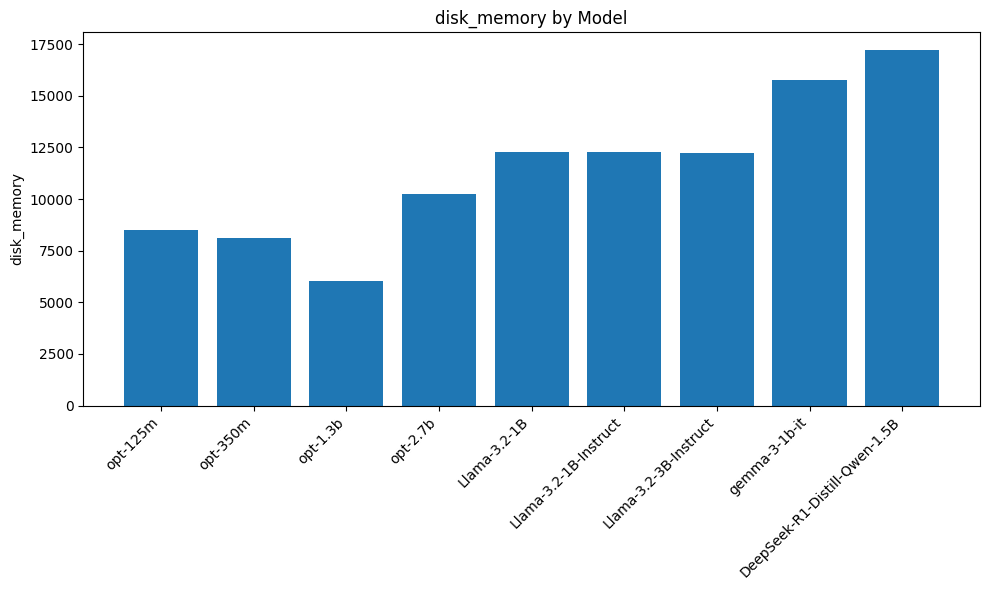

In [6]:
### To Complete ###
metrics = [
    GPUMemoryMetric(mode = "disk"),
    # GPUMemoryMetric(mode = "inference"),
    # GPUMemoryMetric(mode = "training"),
        ]

results_memory = evaluate_models(model_ids, metrics, dataset="WikiText")
plot_results(results_memory, list(results_memory[list(results_memory.keys())[0]].keys())[0])
### End of To Complete ###

### 3.3 Evaluate LLM compute

**Implementation task:**
- Benchmark the LLMs with the MAC metric.
- Plot the results.

**Questions:**
- What is the the type of model with the lowest MAC?
- What is the the size of model with the lowest MAC?
- When is the MAC metric useful?
- What are the limits of the MAC metric?


Evaluating facebook/opt-125m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-125m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'total_macs': 22375283712.0, 'total_params': 123664896.0}

Evaluating facebook/opt-350m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-350m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'total_macs': 59544354816.0, 'total_params': 329097216.0}

Evaluating facebook/opt-1.3b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-1.3b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'total_macs': 237348560896.0, 'total_params': 1311559680.0}

Evaluating facebook/opt-2.7b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'total_macs': 478915921920.0, 'total_params': 2646348800.0}

Evaluating meta-llama/Llama-3.2-1B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=

{'total_macs': 236027641856.0, 'total_params': 1235746816.0}

Evaluating meta-llama/Llama-3.2-1B-Instruct


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

{'total_macs': 236027641856.0, 'total_params': 1235746816.0}

Evaluating meta-llama/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-3B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

{'total_macs': 613601771520.0, 'total_params': 3212574720.0}

Evaluating google/gemma-3-1b-it


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-1b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

{'total_macs': 196951080960.0, 'total_params': 999751680.0}

Evaluating google/gemma-3-4b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-4b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

{'total_macs': 764339322880.0, 'total_params': 3879895040.0}

Evaluating deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', vocab_size=151643, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<｜User｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151645: AddedToken("<｜Assistant｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151646: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|EOT|>", rstrip=F

{'total_macs': 310257451008.0, 'total_params': 1543626752.0}


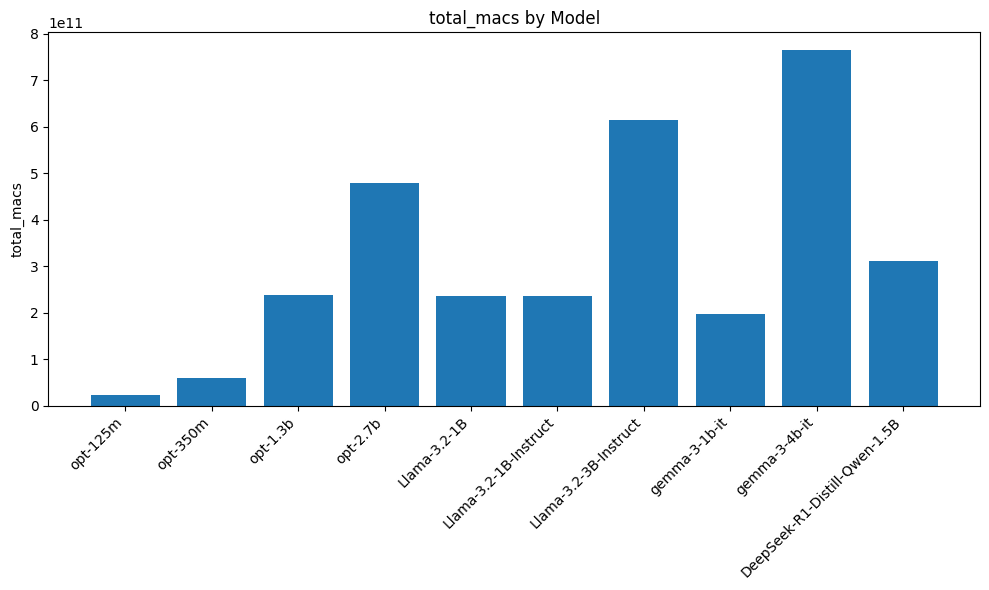

In [7]:
### To Complete ###
metrics = [
    ModelArchitectureMetric()
        ]

results_mac = evaluate_models(model_ids, metrics, dataset="WikiText")
plot_results(results_mac, list(results_mac[list(results_mac.keys())[0]].keys())[0])
### End of To Complete ###

### 3.4 Evaluate LLM latency

**Implementation task:**
- Benchmark the LLMs with the latency metric.
- Plot the results.

**Questions:**
- What is the the type of model with the lowest latency?
- What is the the size of model with the lowest latency?
- When is the latency metric useful?
- What are the limits of the latency metric?


Evaluating facebook/opt-125m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-125m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'inference_elapsed_time_ms_@1': 514.3576340675354, 'inference_latency_ms_@1': 5.143576340675354, 'inference_throughput_batches_per_ms_@1': 0.19441725635371818}

Evaluating facebook/opt-350m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-350m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'inference_elapsed_time_ms_@1': 853.7791705131531, 'inference_latency_ms_@1': 8.53779170513153, 'inference_throughput_batches_per_ms_@1': 0.11712630555263638}

Evaluating facebook/opt-1.3b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-1.3b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'inference_elapsed_time_ms_@1': 1236.0317769050598, 'inference_latency_ms_@1': 12.360317769050598, 'inference_throughput_batches_per_ms_@1': 0.08090406886657336}

Evaluating facebook/opt-2.7b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'inference_elapsed_time_ms_@1': 1933.409878730774, 'inference_latency_ms_@1': 19.334098787307738, 'inference_throughput_batches_per_ms_@1': 0.051722090126924886}

Evaluating meta-llama/Llama-3.2-1B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=

{'inference_elapsed_time_ms_@1': 1433.6848306655884, 'inference_latency_ms_@1': 14.336848306655884, 'inference_throughput_batches_per_ms_@1': 0.06975033693672757}

Evaluating meta-llama/Llama-3.2-1B-Instruct


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

{'inference_elapsed_time_ms_@1': 1420.250979423523, 'inference_latency_ms_@1': 14.20250979423523, 'inference_throughput_batches_per_ms_@1': 0.0704100905042782}

Evaluating meta-llama/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-3B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

{'inference_elapsed_time_ms_@1': 2982.2129859924316, 'inference_latency_ms_@1': 29.822129859924317, 'inference_throughput_batches_per_ms_@1': 0.033532145581051324}

Evaluating google/gemma-3-1b-it


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-1b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

{'inference_elapsed_time_ms_@1': 4307.56734085083, 'inference_latency_ms_@1': 43.0756734085083, 'inference_throughput_batches_per_ms_@1': 0.023214959183957416}

Evaluating google/gemma-3-4b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-4b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

{'inference_elapsed_time_ms_@1': 6457.373554229736, 'inference_latency_ms_@1': 64.57373554229736, 'inference_throughput_batches_per_ms_@1': 0.015486172382655108}

Evaluating deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', vocab_size=151643, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<｜User｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151645: AddedToken("<｜Assistant｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151646: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|EOT|>", rstrip=F

{'inference_elapsed_time_ms_@1': 2377.8603839874268, 'inference_latency_ms_@1': 23.77860383987427, 'inference_throughput_batches_per_ms_@1': 0.04205461374999246}


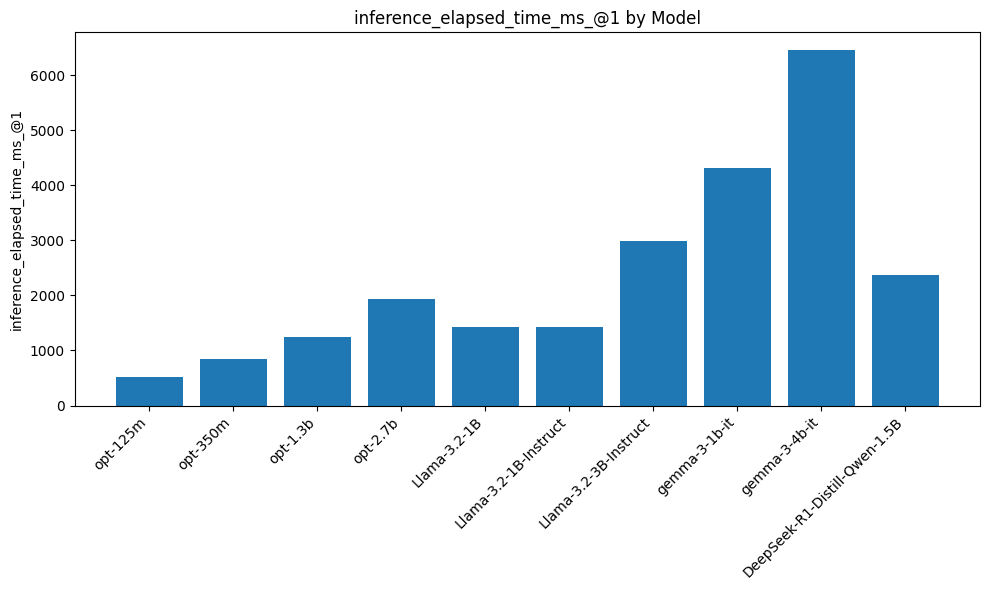

In [8]:
### To Complete ###
metrics = [
    ElapsedTimeMetric(n_iterations = 100,
        n_warmup_iterations = 10,
        device = "cuda",
        timing_type = "sync",)
        ]

results_latency = evaluate_models(model_ids, metrics, dataset="WikiText")
plot_results(results_latency, list(results_latency[list(results_latency.keys())[0]].keys())[0])
### End of To Complete ###

### 3.5 Evaluate LLM energy consumption

**Implementation task:**
- Benchmark the LLMs with the energy metric.
- Plot the results.

**Questions:**
- What is the the type of model with the lowest energy consumption?
- What is the the size of model with the lowest energy consumption?
- When is the energy metric useful?
- What are the limits of the energy metric?


Evaluating facebook/opt-125m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-125m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'Loading model_emissions': 5.454345970827554e-07, 'Loading model_energy_consumed': 9.73312509293091e-06, 'Inference_emissions': 1.6175934078596778e-06, 'Inference_energy_consumed': 2.886549381430214e-05, 'tracker_emissions': 2.167498213083403e-06, 'tracker_energy_consumed': 3.8678388498784824e-05}

Evaluating facebook/opt-350m


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-350m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'Loading model_emissions': 1.0384457674453345e-06, 'Loading model_energy_consumed': 1.8530769061641614e-05, 'Inference_emissions': 3.6371155110178054e-06, 'Inference_energy_consumed': 6.490329076210863e-05, 'tracker_emissions': 4.6840458757773484e-06, 'tracker_energy_consumed': 8.358546504715194e-05}

Evaluating facebook/opt-1.3b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-1.3b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

{'Loading model_emissions': 2.5573047084369633e-06, 'Loading model_energy_consumed': 4.5634374425613646e-05, 'Inference_emissions': 8.535421629293088e-06, 'Inference_energy_consumed': 0.00015231216883408141, 'tracker_emissions': 1.1097136802254265e-05, 'tracker_energy_consumed': 0.00019802524674341555}

Evaluating facebook/opt-2.7b


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GPT2TokenizerFast(name_or_path='facebook/opt-2.7b', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), max_seq_len=None)...
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
INFO - Using provided list of metric instances.
INFO - Evaluating a base model.
INFO - Detected transformers model. Using TransformerHandler.
- The first element of the b

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[codecarbon WARNING @ 23:28:34] Background scheduler didn't run for a long period (2s), results might be inaccurate
[codecarbon INFO @ 23:28:34] Energy consumed for RAM : 0.000008 kWh. RAM Power : 11.638044834136963 W
[codecarbon INFO @ 23:28:34] Energy consumed for all CPUs : 0.000042 kWh. Total CPU Power : 60.0 W
[codecarbon INFO @ 23:28:34] Energy consumed for all GPUs : 0.000087 kWh. Total GPU Power : 122.98155707587706 W
[codecarbon INFO @ 23:28:34] 0.000137 kWh of electricity used since the beginning.
[codecarbon WARNING @ 23:28:37] Background scheduler didn't run for a long period (2s), results might be inaccurate
[codecarbon INFO @ 23:28:37] Energy consumed for RAM : 0.000016 kWh. RAM Power : 11.638044834136963 W
[codecarbon INFO @ 23:28:37] Energy consumed for all CPUs : 0.000081 kWh. Total CPU Power : 60.0 W
[codecarbon INFO @ 23:28:37] Energy consumed for all GPUs : 0.000307 kWh. Total GPU Power : 344.17918360341565 W
[codecarbon INFO @ 23:28:37] 0.000403 kWh of electricity 

{'Loading model_emissions': 7.692214606920622e-06, 'Loading model_energy_consumed': 0.0001372653795913671, 'Inference_emissions': 1.4890195004698163e-05, 'Inference_energy_consumed': 0.0002657112904351998, 'tracker_emissions': 2.258920245421697e-05, 'tracker_energy_consumed': 0.0004030978863687248}

Evaluating meta-llama/Llama-3.2-1B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|end_of_text|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lstrip=

{'Loading model_emissions': 2.2723534599832815e-06, 'Loading model_energy_consumed': 4.054950052612076e-05, 'Inference_emissions': 8.429901761076215e-06, 'Inference_energy_consumed': 0.00015042919682856963, 'tracker_emissions': 1.0711650524190923e-05, 'tracker_energy_consumed': 0.0001911463538641111}

Evaluating meta-llama/Llama-3.2-1B-Instruct


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-1B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

{'Loading model_emissions': 2.409191697418273e-06, 'Loading model_energy_consumed': 4.2991339913600755e-05, 'Inference_emissions': 7.899582442298754e-06, 'Inference_energy_consumed': 0.00014096579957348905, 'tracker_emissions': 1.0318821621027885e-05, 'tracker_energy_consumed': 0.00018413643393043922}

Evaluating meta-llama/Llama-3.2-3B-Instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=PreTrainedTokenizerFast(name_or_path='meta-llama/Llama-3.2-3B-Instruct', vocab_size=128000, model_max_length=131072, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|begin_of_text|>', 'eos_token': '<|eot_id|>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	128000: AddedToken("<|begin_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("<|end_of_text|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128002: AddedToken("<|reserved_special_token_0|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128003: AddedToken("<|reserved_special_token_1|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128004: AddedToken("<|finetune_right_pad_id|>", rstrip=False, lst

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[codecarbon WARNING @ 23:30:35] Background scheduler didn't run for a long period (3s), results might be inaccurate
[codecarbon INFO @ 23:30:35] Energy consumed for RAM : 0.000011 kWh. RAM Power : 11.638044834136963 W
[codecarbon INFO @ 23:30:35] Energy consumed for all CPUs : 0.000056 kWh. Total CPU Power : 60.0 W
[codecarbon INFO @ 23:30:35] Energy consumed for all GPUs : 0.000114 kWh. Total GPU Power : 121.61754577734722 W
[codecarbon INFO @ 23:30:35] 0.000181 kWh of electricity used since the beginning.
[codecarbon WARNING @ 23:30:39] Background scheduler didn't run for a long period (2s), results might be inaccurate
[codecarbon INFO @ 23:30:39] Energy consumed for RAM : 0.000020 kWh. RAM Power : 11.638044834136963 W
[codecarbon INFO @ 23:30:39] Energy consumed for all CPUs : 0.000104 kWh. Total CPU Power : 60.0 W
[codecarbon INFO @ 23:30:39] Energy consumed for all GPUs : 0.000383 kWh. Total GPU Power : 340.20845539719477 W
[codecarbon INFO @ 23:30:39] 0.000507 kWh of electricity 

{'Loading model_emissions': 1.0115770708412814e-05, 'Loading model_energy_consumed': 0.00018051304820594253, 'Inference_emissions': 1.829016577457666e-05, 'Inference_energy_consumed': 0.00032638280080973353, 'tracker_emissions': 2.8426343158244142e-05, 'tracker_energy_consumed': 0.0005072600003255615}

Evaluating google/gemma-3-1b-it


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-1b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

{'Loading model_emissions': 2.0907351157513197e-06, 'Loading model_energy_consumed': 3.7308572882301956e-05, 'Inference_emissions': 1.7761330738214737e-05, 'Inference_energy_consumed': 0.0003169458901517646, 'tracker_emissions': 1.9855690515933897e-05, 'tracker_energy_consumed': 0.0003543191440948963}

Evaluating google/gemma-3-4b-it


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=GemmaTokenizerFast(name_or_path='google/gemma-3-4b-it', vocab_size=262144, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<bos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'boi_token': '<start_of_image>', 'eoi_token': '<end_of_image>', 'image_token': '<image_soft_token>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("<eos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<bos>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("<m

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

ERROR - Error casting model to device: cuda. Skipping device casting.
[codecarbon WARNING @ 23:32:46] Background scheduler didn't run for a long period (9s), results might be inaccurate
[codecarbon INFO @ 23:32:46] Energy consumed for RAM : 0.000032 kWh. RAM Power : 11.638044834136963 W
[codecarbon INFO @ 23:32:46] Energy consumed for all CPUs : 0.000164 kWh. Total CPU Power : 60.0 W
[codecarbon INFO @ 23:32:46] Energy consumed for all GPUs : 0.000146 kWh. Total GPU Power : 53.14263302818369 W
[codecarbon INFO @ 23:32:46] 0.000342 kWh of electricity used since the beginning.
[codecarbon WARNING @ 23:32:54] Background scheduler didn't run for a long period (6s), results might be inaccurate
[codecarbon INFO @ 23:32:54] Energy consumed for RAM : 0.000053 kWh. RAM Power : 11.638044834136963 W
[codecarbon INFO @ 23:32:54] Energy consumed for all CPUs : 0.000272 kWh. Total CPU Power : 60.0 W
[codecarbon INFO @ 23:32:54] Energy consumed for all GPUs : 0.000624 kWh. Total GPU Power : 267.08564

{'Loading model_emissions': 1.9165362552251838e-05, 'Loading model_energy_consumed': 0.00034200043812794367, 'Inference_emissions': 3.397120451911492e-05, 'Inference_energy_consumed': 0.0006062064726193351, 'tracker_emissions': 5.3143204379385875e-05, 'tracker_energy_consumed': 0.0009483253516191557}

Evaluating deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B


INFO - Testing compatibility with functools.partial(<function text_generation_collate at 0x7fa14a89f2e0>, tokenizer=LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B', vocab_size=151643, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<｜User｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151645: AddedToken("<｜Assistant｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151646: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|EOT|>", rstrip=F

{'Loading model_emissions': 3.320983568083853e-06, 'Loading model_energy_consumed': 5.9262006247146676e-05, 'Inference_emissions': 1.2035715815116958e-05, 'Inference_energy_consumed': 0.00021477392200283654, 'tracker_emissions': 1.536719729763827e-05, 'tracker_energy_consumed': 0.0002742232605442329}


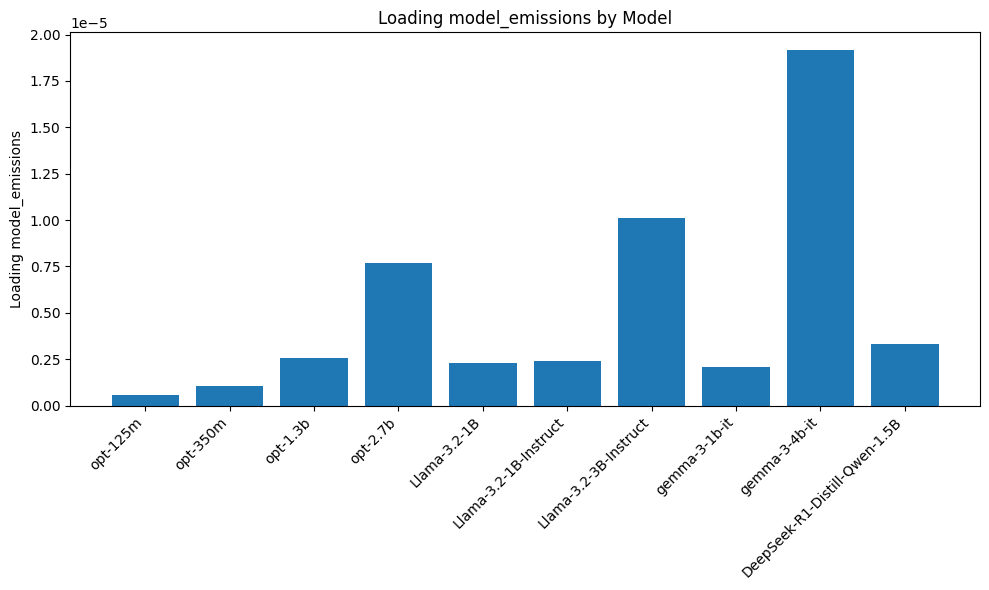

In [9]:
### To Complete ###
metrics = [
    EnergyMetric(n_iterations = 100,
                 n_warmup_iterations = 10,
                 device = "cuda")
        ]

results_energy = evaluate_models(model_ids, metrics, dataset="WikiText")
plot_results(results_energy, list(results_energy[list(results_energy.keys())[0]].keys())[0])
### End of To Complete ###

### 3.6 Compare LLM on a pareto front

**Implementation task:**
- Plot the results of the previous metrics in a pareto front. You can use the files containing the saved results when evaluating the previous metrics.

**Questions:**
- What is the best model on the pareto front?

In [37]:
def plot_pareto_front(metric1_results, metric2_results, metric1_name, metric2_name):
    """
    Plot pareto front comparing two metrics across models.
    
    Args:
        metric1_results: Results dictionary for first metric
        metric2_results: Results dictionary for second metric 
        metric1_name: Name of first metric to display
        metric2_name: Name of second metric to display
    """
    # Extract values for each model
    models = []
    metric1_values = []
    metric2_values = []
    
    for model_name in metric1_results.keys():
        if model_name in metric1_results and model_name in metric2_results:
            models.append(model_name)
            metric1_values.append(metric1_results[model_name][metric1_name])
            metric2_values.append(metric2_results[model_name][metric2_name])
        else:
            print(f"{model_name} missed evaluation.")
    
    # Create scatter plot
    plt.figure(figsize=(10,6))
    print(metric2_values)
    plt.scatter(metric1_values, metric2_values)
    
    # Add labels for each point
    for i, model in enumerate(models):
        plt.annotate(model, (metric1_values[i], metric2_values[i]))
        
    plt.xlabel(metric1_name)
    plt.ylabel(metric2_name)
    plt.title(f'Pareto Front: {metric1_name} vs {metric2_name}')
    plt.grid(True)
    plt.show()


[5.143576340675354, 8.53779170513153, 12.360317769050598, 19.334098787307738, 14.336848306655884, 14.20250979423523, 29.822129859924317, 43.0756734085083, 64.57373554229736, 23.77860383987427]


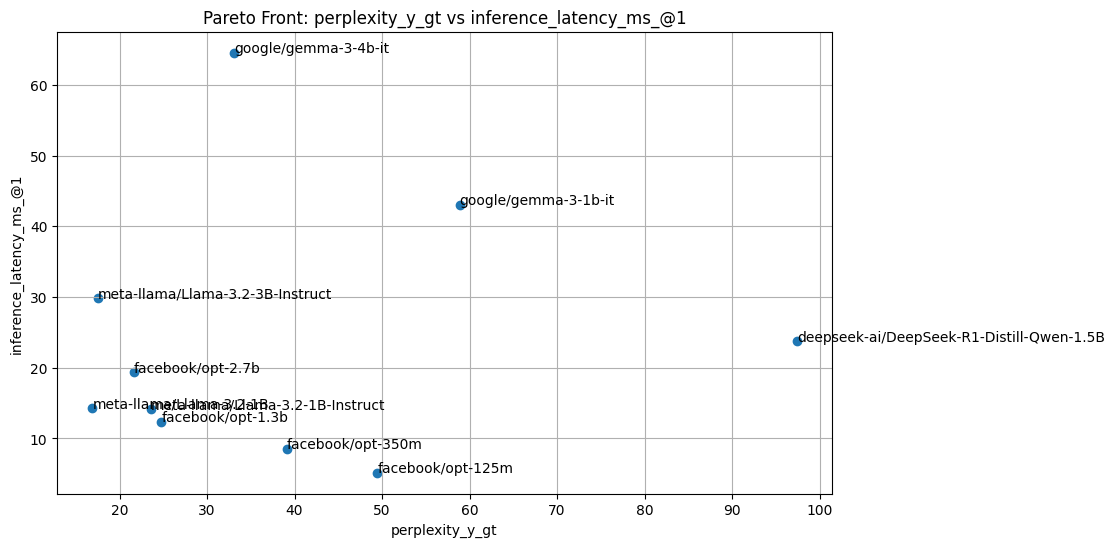

google/gemma-3-4b-it missed evaluation.
[8490.38525390625, 8112.38525390625, 6050.38525390625, 10246.0, 12272.83984375, 12272.83984375, 12244.0, 15760.7529296875, 17209.99560546875]


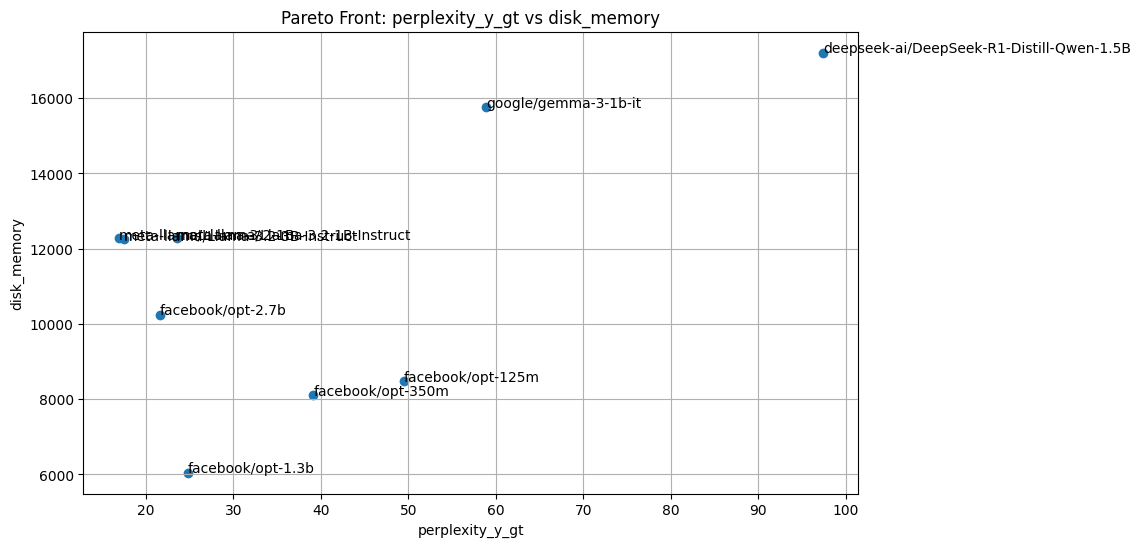

[22375283712.0, 59544354816.0, 237348560896.0, 478915921920.0, 236027641856.0, 236027641856.0, 613601771520.0, 196951080960.0, 764339322880.0, 310257451008.0]


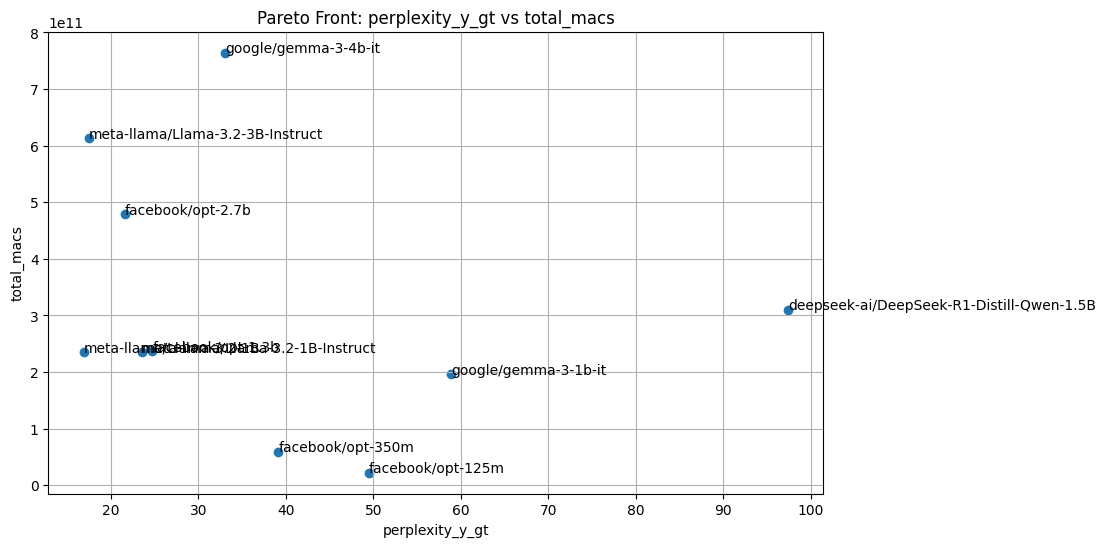

[123664896.0, 329097216.0, 1311559680.0, 2646348800.0, 1235746816.0, 1235746816.0, 3212574720.0, 999751680.0, 3879895040.0, 1543626752.0]


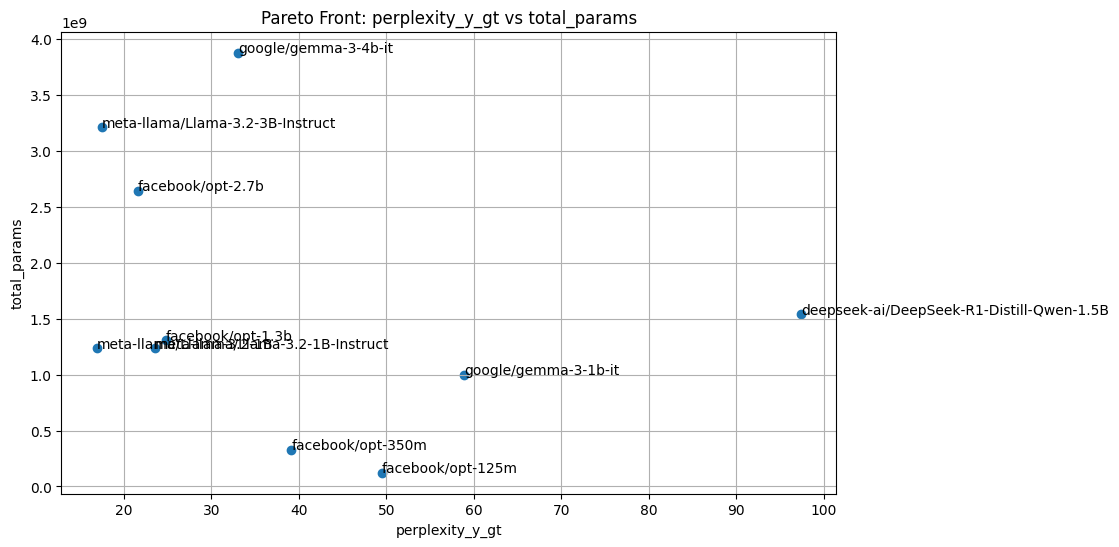

[1.6175934078596778e-06, 3.6371155110178054e-06, 8.535421629293088e-06, 1.4890195004698163e-05, 8.429901761076215e-06, 7.899582442298754e-06, 1.829016577457666e-05, 1.7761330738214737e-05, 3.397120451911492e-05, 1.2035715815116958e-05]


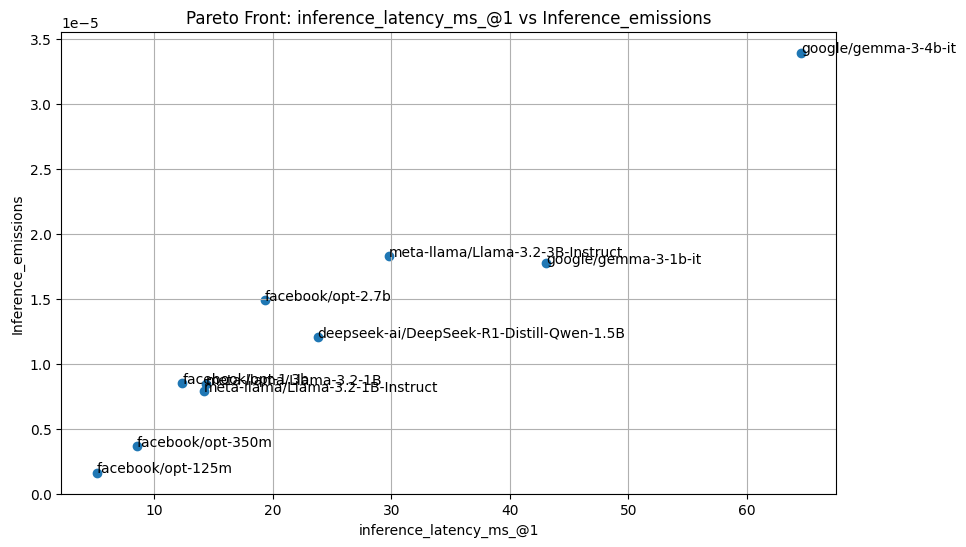

[22375283712.0, 59544354816.0, 237348560896.0, 478915921920.0, 236027641856.0, 236027641856.0, 613601771520.0, 196951080960.0, 764339322880.0, 310257451008.0]


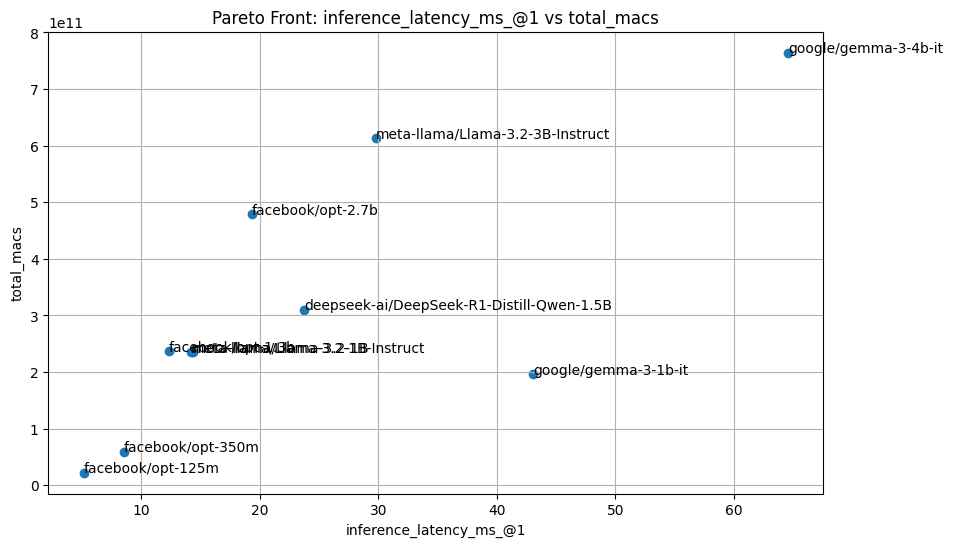

In [38]:
plot_pareto_front(results_perplexity, results_latency, "perplexity_y_gt", "inference_latency_ms_@1")
plot_pareto_front(results_perplexity, results_memory, "perplexity_y_gt", "disk_memory")
plot_pareto_front(results_perplexity, results_mac, "perplexity_y_gt", "total_macs")
plot_pareto_front(results_perplexity, results_mac, "perplexity_y_gt", "total_params")
plot_pareto_front(results_latency, results_energy, "inference_latency_ms_@1", "Inference_emissions")
plot_pareto_front(results_latency, results_mac, "inference_latency_ms_@1", "total_macs")

## 4. Bonus: Evaluate the quality and efficiency with different context lengths